✅ MAE: 0.05
✅ MSE: 0.01


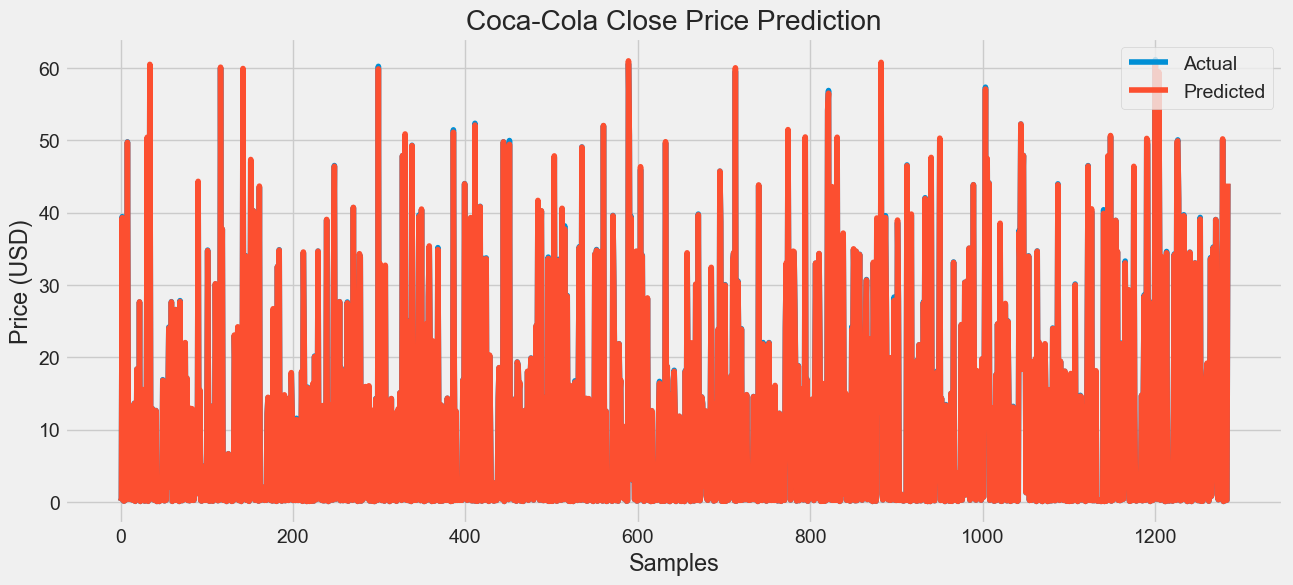

In [18]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from finta import TA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

# === Load Historical CSV ===
data = pd.read_csv("Coca-Cola_stock_history.csv")
data['Date'] = pd.to_datetime(data['Date'], errors='coerce', utc=True)
data.dropna(subset=['Date'], inplace=True)
data.sort_values('Date', inplace=True)
data.reset_index(drop=True, inplace=True)

# === Preprocessing and Indicators ===
data.ffill(inplace=True)
data.fillna(0, inplace=True)

data['RSI'] = TA.RSI(data)
macd = TA.MACD(data)
data['MACD'] = macd['MACD']
data['Signal'] = macd['SIGNAL']
data['ATR'] = TA.ATR(data)

data['MA_20'] = data['Close'].rolling(20).mean()
data['MA_50'] = data['Close'].rolling(50).mean()
data['Daily_Return'] = data['Close'].pct_change()
data['Volatility'] = data['Daily_Return'].rolling(20).std()
data.dropna(inplace=True)

# === Features ===
features = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits',
            'MA_20', 'MA_50', 'Daily_Return', 'Volatility',
            'RSI', 'MACD', 'Signal', 'ATR']
target = 'Close'

X = data[features]
y = data[target]

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Train Model ===
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# === Evaluation ===
print(f"✅ MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"✅ MSE: {mean_squared_error(y_test, y_pred):.2f}")

# === Plot ===
plt.figure(figsize=(14,6))
plt.plot(np.array(y_test.reset_index(drop=True)), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Coca-Cola Close Price Prediction")
plt.xlabel("Samples")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()



📈 Live Prediction using yfinance (latest day):
📊 Live data columns: ['Date', 'ko_open', 'ko_high', 'ko_low', 'ko_close', 'ko_adj close', 'ko_volume']
🔮 Predicted Close Price (latest day): $59.73


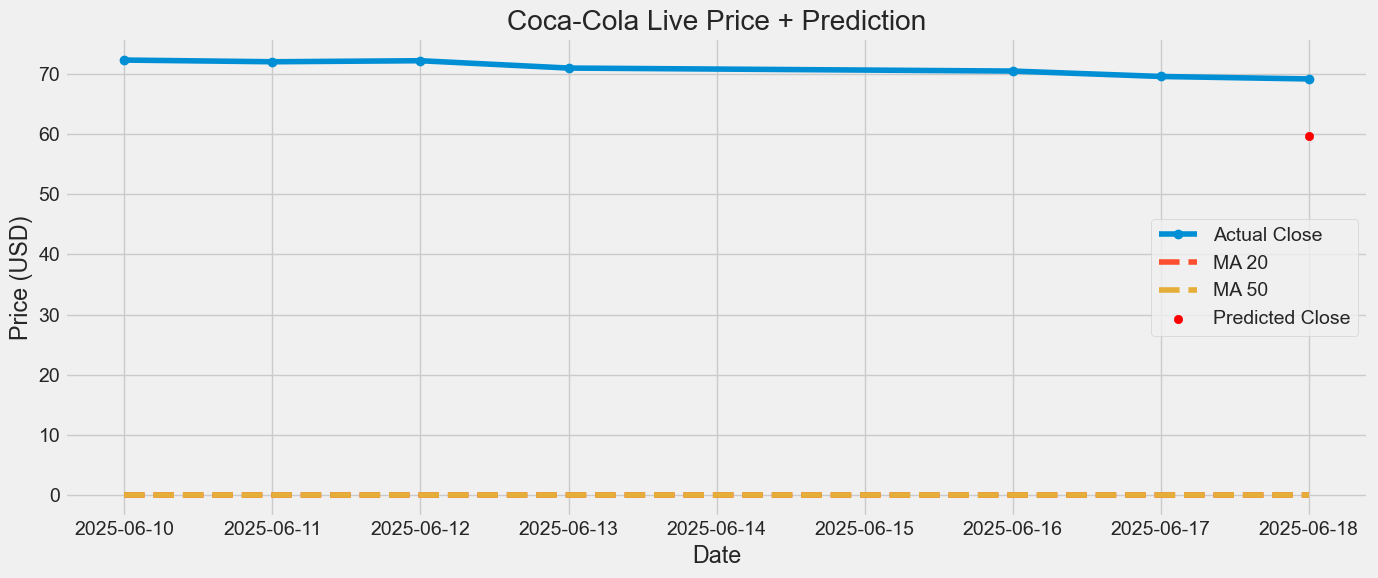

In [20]:
print("\n📈 Live Prediction using yfinance (latest day):")

try:
    # Download data
    live = yf.download("KO", period="7d", interval="1d", auto_adjust=False, group_by='ticker', progress=False)

    # Flatten columns
    if isinstance(live.columns, pd.MultiIndex):
        live.columns = ['_'.join(col).strip().lower() for col in live.columns]
    else:
        live.columns = [str(c).strip().lower().replace(" ", "_") for c in live.columns]

    live.reset_index(inplace=True)
    live.ffill(inplace=True)
    live.fillna(0, inplace=True)

    print("📊 Live data columns:", live.columns.tolist())

    # Rename to match training feature names
    rename_map = {
        'ko_open': 'Open',
        'ko_high': 'High',
        'ko_low': 'Low',
        'ko_close': 'Close',
        'ko_volume': 'Volume',
        'ko_dividends': 'Dividends',
        'ko_stock_splits': 'Stock Splits',
    }
    live.rename(columns=rename_map, inplace=True)

    for col in ['Dividends', 'Stock Splits']:
        if col not in live.columns:
            live[col] = 0.0

    required = {'Open', 'High', 'Low', 'Close', 'Volume'}
    if not required.issubset(live.columns):
        raise ValueError(f"Missing required columns in live data: {required - set(live.columns)}")

    # Indicators
    live['RSI'] = TA.RSI(live)
    macd = TA.MACD(live)
    live['MACD'] = macd['MACD']
    live['Signal'] = macd['SIGNAL']
    live['ATR'] = TA.ATR(live)
    live['MA_20'] = live['Close'].rolling(20).mean()
    live['MA_50'] = live['Close'].rolling(50).mean()
    live['Daily_Return'] = live['Close'].pct_change()
    live['Volatility'] = live['Daily_Return'].rolling(20).std()
    live.ffill(inplace=True)
    live.fillna(0, inplace=True)

    # Match features for prediction
    features_live = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits',
                     'MA_20', 'MA_50', 'Daily_Return', 'Volatility',
                     'RSI', 'MACD', 'Signal', 'ATR']

    latest_input = live[features_live].iloc[-1:]
    live_prediction = model.predict(latest_input)[0]
    print(f"🔮 Predicted Close Price (latest day): ${live_prediction:.2f}")

except Exception as e:
    print(f"❌ Live prediction failed: {e}")


plt.figure(figsize=(14, 6))
plt.plot(live['Date'], live['Close'], label='Actual Close', marker='o')
plt.plot(live['Date'], live['MA_20'], label='MA 20', linestyle='--')
plt.plot(live['Date'], live['MA_50'], label='MA 50', linestyle='--')

# Highlight the latest prediction
plt.scatter(live['Date'].iloc[-1], live_prediction, color='red', label='Predicted Close', zorder=5)

plt.title("Coca-Cola Live Price + Prediction")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
